### **Miguel Angel Alvarez Guzman**

# Laboratorio 2

### **Cuantizacion de una señal**

**Objetivos:**

**realizar la cuantizacion de una señal ya discretizada con los siguientes parametros:**
- se usaran 6 bits, 16 para positivos y negativos, y uno para paridad
- se redondeara al mayor
- se usara el bit menos significativo para paridad
- se usara el bit mas significativo para el signo
- la señal tiene un ancho de banda de 4khz
- se muestrea a 8000 muestras/s
- cada bit dura 1/48000 segundos en la codificacion
- la codificacion se dara en señales cuadradas unipolares, bipolar, manchester y manchester diferencial
- señal informacion senosoidal 4khz +-15v



### Bloque Informacion

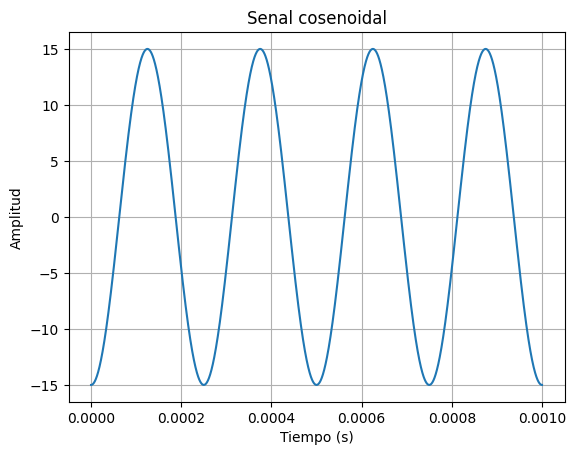

4001

In [238]:
import numpy, scipy.special, scipy.stats
import matplotlib.pyplot as plt

# Definicion de funcion generadora de senoidal

def señal_cosenoidal(f, A=1, phi=0,     duracion=None):
    duracion = 4 / f if duracion is None else duracion
    fs = 1000 * f  # frecuencia de muestreo
    t = numpy.arange(0, duracion, 1/fs)
    x = A * numpy.cos(2 * numpy.pi * f * t )
    return t, x
def señal_constante(f, A):
    fs = 1000 * f  # frecuencia de muestreo
    duracion = 4 / f
    t = numpy.arange(0, duracion, 1/fs)
    x = A * numpy.ones_like(t)
    return t, x
# Prueba de senal senoidal
f = 4000      # frecuencia de la senal
A = -15      # amplitud de la senal
ta, xa = señal_cosenoidal(f, A)
plt.figure()
plt.plot(ta, xa)
plt.title('Senal cosenoidal')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.grid()
plt.show()

# funcion para aplicacion de transformada de Fourier a senoidal
def aplicar_fft(x, fs):
    N = len(x)
    X = numpy.fft.fft(x)
    X = numpy.fft.fftshift(X)  # centrar la FFT
    f = numpy.fft.fftfreq(N, 1/fs)
    f = numpy.fft.fftshift(f)  # centrar las frecuencias
    return f, X
len(ta)

### Parte Muestreo

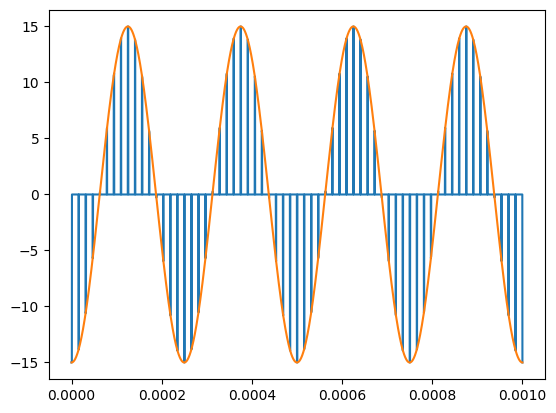

In [243]:
def modulacion_mult(f1, f2, A1=1, A2=1, duty_cycle=0.5):
    # Duracion de 4 ciclos de la senal de menor frecuencia
    duracion = 4 / f
    fs = 1000 * f  # frecuencia de muestreo
    t = numpy.arange(0, duracion, 1/fs)
    x1 = xa
    x2 = A2 * scipy.signal.square(2 * numpy.pi * f2 * t, duty=duty_cycle)+A2
    x = x1 * x2
    return t, x
# Prueba de modulacion
t, x = modulacion_mult(4000,64000,15,0.5,0.05)
plt.figure()
plt.plot(t, x)
plt.plot(ta,xa)
plt.show()


### Parte Cuantizacion

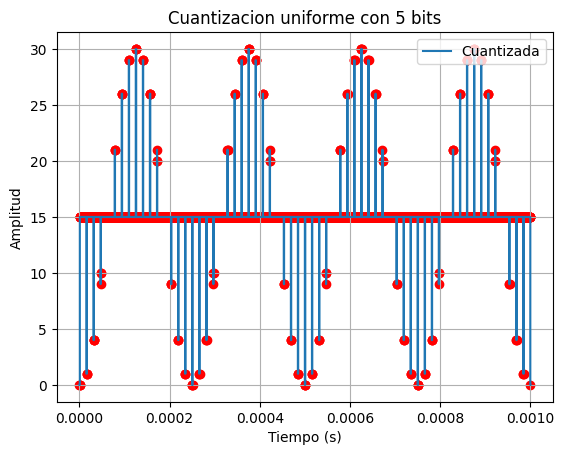

[ 0  0  0 ... 15 15  0]
4000000


In [323]:
# Se toma el valor maximo por intervalos de la muestreada y se le asigna el valor del tiempo, la cuantizacion
# se deve hacer usando el bit mas significativo como el signo, el menos significativo como paridad par y el byte 0x00 como 0

def cuantizacion_uniforme(x, num_bits):
    # Numero de niveles de cuantizacion
    L = 2 ** num_bits
    # Rango de la senal
    x_min = numpy.min(x)
    x_max = numpy.max(x)
    # Paso de cuantizacion
    delta = (x_max - x_min) / L
    # Niveles de cuantizacion
    niveles = numpy.linspace(x_min + delta/2, x_max - delta/2, L)
    # Cuantizacion
    x_cuantizada = numpy.zeros_like(x)
    for i in range(len(x)):
        indice = int((x[i] - x_min) / delta)
        if indice < 0:
            indice = 0
        elif indice >= L:
            indice = L - 1
        x_cuantizada[i] = niveles[indice]
    # convertir niveles a enteros de num_bits bits
    x_cuantizada = ((x_cuantizada - x_min) / (x_max - x_min) * (2**num_bits - 1)).astype(int)
    return x_cuantizada
# Prueba de cuantizacion uniforme
num_bits = 5
x_cuantizada = cuantizacion_uniforme(x, num_bits)
plt.figure()
#plt.plot(t, x, label='Original')
plt.step(t, x_cuantizada, label='Cuantizada', where='mid')
plt.scatter(t, x_cuantizada, color='red')
plt.title('Cuantizacion uniforme con {} bits'.format(num_bits))
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')  
plt.legend()
plt.grid()
plt.show()
print(x_cuantizada)

#Agregar bit menos significativo de paridad
def agregar_paridad(x_cuantizada, num_bits):
    x_paridad = numpy.zeros(len(x_cuantizada), dtype=int)
    for i in range(len(x_cuantizada)):
        byte = x_cuantizada[i]
        paridad = bin(byte).count('1') % 2  # paridad par
        byte = (byte << 1) | paridad  # agregar bit de paridad al final
        x_paridad[i] = byte
    return x_paridad
x_paridad = agregar_paridad(x_cuantizada, num_bits)

print(fs)


### Codificacion de linea

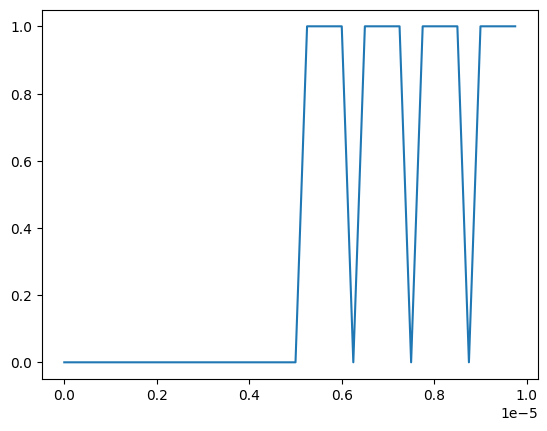

In [324]:
# se realiza codificacion de la codificacion en formatos unipolares, bipolar, manchester y manchester diferencial

def codificacion_unipolar(x_cuantizada, num_bits):
    # Convertir a binario
    x_binario = [numpy.binary_repr(val, width=num_bits) for val in x_cuantizada]
    # Codificacion unipolar
    x_unipolar = []
    for byte in x_binario:
        for bit in byte:
            if bit == '1':
                x_unipolar.append(1)
            else:
                x_unipolar.append(0)
    return x_unipolar
def codificacion_bipolar(x_cuantizada, num_bits):
    # Convertir a binario
    x_binario = [numpy.binary_repr(val, width=num_bits) for val in x_cuantizada]
    # Codificacion bipolar
    x_bipolar = []
    for byte in x_binario:
        for bit in byte:
            if bit == '1':
                x_bipolar.append(1)
            else:
                x_bipolar.append(-1)
    return x_bipolar
def codificacion_manchester(x_cuantizada, num_bits):
    # Convertir a binario
    x_binario = [numpy.binary_repr(val, width=num_bits) for val in x_cuantizada]
    # Codificacion manchester
    x_manchester = []
    for byte in x_binario:
        for bit in byte:
            if bit == '1':
                x_manchester.append(1)
                x_manchester.append(-1)
            else:
                x_manchester.append(-1)
                x_manchester.append(1)
    return x_manchester
def codificacion_manchester_diferencial(x_cuantizada, num_bits):
    # Convertir a binario
    x_binario = [numpy.binary_repr(val, width=num_bits) for val in x_cuantizada]
    # Codificacion manchester diferencial
    x_manchester_diff = []
    ultimo_bit = -1  # suponer que el ultimo bit fue -1
    for byte in x_binario:
        for bit in byte:
            if bit == '1':
                ultimo_bit = -ultimo_bit
                x_manchester_diff.append(ultimo_bit)
                x_manchester_diff.append(-ultimo_bit)
            else:
                x_manchester_diff.append(ultimo_bit)
                x_manchester_diff.append(-ultimo_bit)
    return x_manchester_diff
# Prueba de codificacion
x_unipolar = codificacion_unipolar(x_cuantizada, num_bits)
x_unipolar_Graficar = x_unipolar[:int(len(t)/100)]
tiempo_unipolar = t[:int(len(t)/100)]
#Grafica de codificacion unipolar
plt.figure()
plt.plot(tiempo_unipolar,x_unipolar_Graficar)

### Creacion del canal

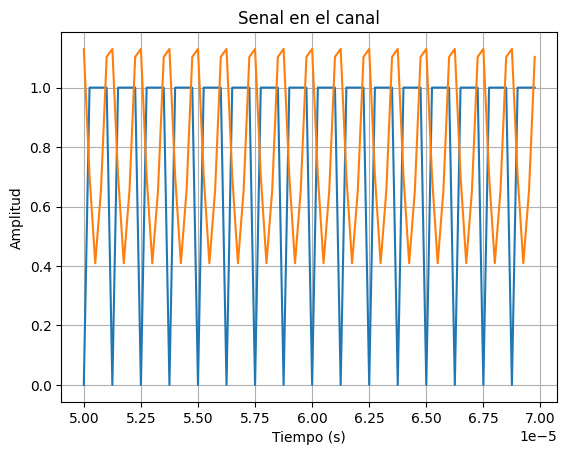

In [322]:
# Se debe simular un canal que contenga un LPF, atenuacion y ruido gaussiano
### Creacion del canal
from scipy.signal import lfilter
def filtro_LTF(f_c, fs, orden=5):
    # f_c: frecuencia de corte
    # fs: frecuencia de muestreo
    # orden: orden del filtro
    from scipy.signal import butter, lfilter
    nyquist = 0.5 * fs
    normal_cutoff = f_c / nyquist
    b, a = butter(orden, normal_cutoff, btype='low', analog=False)
    return b, a
# Aplicacion de filtro LTF a senal modulada
def aplicar_filtro(x, b, a):
    y = lfilter(b, a, x)
    return y
def crear_canal(x, fs, fc, atenuacion_db):
    # Filtro LTF
    b, a = filtro_LTF(fc, fs)
    x_filtrada = aplicar_filtro(x, b, a)
    # Atenuacion
    atenuacion = 10 ** (atenuacion_db / 20)
    x_atenuada = x_filtrada * atenuacion

    return x_atenuada
# Prueba de canal
fs = 1000 * 4000  # frecuencia de muestreo
fc = 1000000  # frecuencia de corte del filtro
atenuacion_db = 0  # atenuacion en dB
#aplicar el canal a la señal con codificacion unipolar
x_canal = crear_canal(x_unipolar, fs, fc, atenuacion_db)
plt.figure()
longitud=int(len(t)/50)
tempo=200
plt.plot(t[tempo:longitud+tempo],x_unipolar[tempo:longitud+tempo], label='Senal unipolar')
plt.plot(t[tempo:longitud+tempo],x_canal[tempo:longitud+tempo], label='Senal en el canal')
plt.title('Senal en el canal')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.grid()
plt.show()
